## Decision Tree classifier for the Breast Cancer Dataset with ID3 and no pruning

In [57]:

import numpy as np
from math import log
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# ------------------ Supporting Functions ------------------

def countResult(rows):
    """
    Counts the number of each class label in the dataset.
    :param rows: List of data instances, each ending with the class label.
    :return: Dictionary with class labels as keys and their counts as values.
    """
    results = {}
    for row in rows:
        r = row[-1]
        if r not in results:
            results[r] = 0
        results[r] += 1
    return results

def entropy(rows):
    """
    Calculates the entropy of a dataset.
    :param rows: List of data instances, each ending with the class label.
    :return: Entropy value.
    """
    results = countResult(rows)
    ent = 0.0
    for r in results.keys():
        p = float(results[r]) / len(rows)
        ent -= p * (log(p) / log(2)) if p != 0 else 0
    return ent

# ------------------ Tree Node Class ------------------

class treeNode:
    def __init__(self, column=-1, value=None, results=None, trueBranch=None, falseBranch=None):
        """
        Initializes a tree node.
        :param column: Index of the feature used for splitting.
        :param value: Threshold value for the split.
        :param results: Dictionary of class counts if the node is a leaf.
        :param trueBranch: Subtree for instances where feature >= value.
        :param falseBranch: Subtree for instances where feature < value.
        """
        self.column = column
        self.value = value
        self.results = results
        self.trueBranch = trueBranch
        self.falseBranch = falseBranch

# ------------------ Decision Tree Building (ID3) ------------------

def divideset(rows, column, value):
    """
    Divides a set of rows into two based on a column and a value.
    :param rows: List of data instances.
    :param column: Feature index to split on.
    :param value: Threshold value for the split.
    :return: Tuple of two lists: (set1, set2).
    """
    set1 = [row for row in rows if row[column] >= value]
    set2 = [row for row in rows if row[column] < value]
    return set1, set2

def buildtree(rows, headers):
    """
    Builds the decision tree using the ID3 algorithm.
    :param rows: List of data instances.
    :param headers: List of feature names.
    :return: Root node of the decision tree.
    """
    if len(rows) == 0:
        return treeNode()
    
    current_entropy = entropy(rows)
    best_gain = 0.0
    best_criteria = None
    best_sets = None

    # Iterate over all features
    for column in range(len(rows[0]) - 1):
        # Get all unique values in this column
        column_values = set(row[column] for row in rows)
        
        # Iterate over all unique values to consider splits
        for value in column_values:
            set1, set2 = divideset(rows, column, value)
            
            if len(set1) == 0 or len(set2) == 0:
                continue
            
            # Calculate entropy for the split
            p = float(len(set1)) / len(rows)
            gain = current_entropy - p * entropy(set1) - (1 - p) * entropy(set2)
            
            if gain > best_gain:
                best_gain = gain
                best_criteria = (column, value)
                best_sets = (set1, set2)
    
    if best_gain > 0:
        trueBranch = buildtree(best_sets[0], headers)
        falseBranch = buildtree(best_sets[1], headers)
        return treeNode(column=best_criteria[0], value=best_criteria[1],
                       trueBranch=trueBranch, falseBranch=falseBranch)
    else:
        return treeNode(results=countResult(rows))

# ------------------ Prediction Function ------------------

def classify(input, tree):
    """
    Classifies an input instance using the decision tree.
    :param input: List of feature values for the instance.
    :param tree: Root node of the decision tree.
    :return: Predicted class label.
    """
    if tree.results is not None:
        # Return the class with the highest count
        return max(tree.results.items(), key=lambda x: x[1])[0]
    else:
        v = input[tree.column]
        branch = None
        if v >= tree.value:
            branch = tree.trueBranch
        else:
            branch = tree.falseBranch
        return classify(input, branch)

def predict_all(tree, rows):
    """
    Makes predictions for a list of instances.
    :param tree: Root node of the decision tree.
    :param rows: List of data instances.
    :return: List of predicted class labels.
    """
    predictions = []
    for row in rows:
        prediction = classify(row[:-1], tree)
        predictions.append(prediction)
    return predictions

# ------------------ Pruning Function ------------------

def pruning(tree, validation_set, headers):
    """
    Prunes the decision tree using Reduced Error Pruning.
    :param tree: Root node of the decision tree.
    :param validation_set: List of validation instances.
    :param headers: List of feature names.
    :return: Pruned tree.
    """
    if tree.results is not None:
        return tree  # Leaf node, nothing to prune
    
    # Prune branches first
    if tree.trueBranch is not None:
        tree.trueBranch = pruning(tree.trueBranch, validation_set, headers)
    if tree.falseBranch is not None:
        tree.falseBranch = pruning(tree.falseBranch, validation_set, headers)
    
    # If both branches are leaves, consider pruning this node
    if tree.trueBranch.results is not None and tree.falseBranch.results is not None:
        # Current accuracy
        correct = 0
        for row in validation_set:
            y_hat = classify(row[:-1], tree)
            if y_hat == row[-1]:
                correct += 1
        current_accuracy = correct / len(validation_set)
        
        # Create a leaf node with combined results
        combined_results = countResult(tree.trueBranch.results.items())
        combined_results = {}
        for key, value in tree.trueBranch.results.items():
            combined_results[key] = combined_results.get(key, 0) + value
        for key, value in tree.falseBranch.results.items():
            combined_results[key] = combined_results.get(key, 0) + value
        
        # Majority class after merging
        majority_class = max(combined_results.items(), key=lambda x: x[1])[0]
        
        # Calculate accuracy if we prune this node
        pruned_correct = sum(1 for row in validation_set if majority_class == row[-1])
        pruned_accuracy = pruned_correct / len(validation_set)
        
        # If pruning does not decrease accuracy, prune the node
        if pruned_accuracy >= current_accuracy:
            print(f"Pruning node on feature '{headers[tree.column]}' with value {tree.value}")
            tree.trueBranch = None
            tree.falseBranch = None
            tree.results = {majority_class: combined_results[majority_class]}
    
    return tree

# ------------------ Visualization Function ------------------

def print_tree(node, headers, depth=0):
    """
    Prints the decision tree in a readable format.
    :param node: Current node in the tree.
    :param headers: List of feature names.
    :param depth: Current depth for indentation.
    """
    indent = "  " * depth
    if node.results is not None:
        # Leaf node
        print(f"{indent}Predict: {node.results}")
    else:
        # Decision node
        feature = headers[node.column]
        print(f"{indent}If {feature} >= {node.value}:")
        print_tree(node.trueBranch, headers, depth + 1)
        print(f"{indent}Else:")
        print_tree(node.falseBranch, headers, depth + 1)

# ------------------ Data Preparation ------------------

# Load the dataset
data, target = load_breast_cancer(as_frame=True, return_X_y=True)

# Combine data and target
dataset = data.copy()
dataset['target'] = target

# Convert the dataset to a list of lists
rows = dataset.values.tolist()

# Define headers
headers = list(data.columns)

# ------------------ Data Splitting ------------------

# Desired split proportions
train_size = 0.7
validation_size = 0.1
test_size = 0.2

# First split: 70% training and 30% temp (validation + test)
train_rows, temp_rows = train_test_split(
    rows,
    test_size=(validation_size + test_size),
    random_state=42,
    stratify=[row[-1] for row in rows]
)

# Second split: from temp_rows, split into validation and test sets
# Since temp_size = 0.3, validation_size = 0.1, test_size = 0.2
# Therefore, validation_size / temp_size = 0.1 / 0.3 = ~0.3333
validation_rows, test_rows = train_test_split(
    temp_rows,
    test_size=test_size / (validation_size + test_size),  # 0.2 / 0.3 ≈ 0.6666
    random_state=42,
    stratify=[row[-1] for row in temp_rows]
)

print(f"Dataset split:")
print(f"Training set: {len(train_rows)} samples")
print(f"Validation set: {len(validation_rows)} samples")
print(f"Test set: {len(test_rows)} samples")

# ------------------ Build the Decision Tree ------------------

print("\nBuilding the decision tree...")
tree = buildtree(train_rows, headers)
print("Decision tree built successfully.")

# ------------------ Initial Evaluation ------------------

# Validation accuracy
correct = 0
for row in validation_rows:
    y_valid = row[-1]
    y_hat = classify(row[:-1], tree)
    if y_valid == y_hat:
        correct += 1
validation_accuracy = correct / len(validation_rows)
print(f"Initial Validation Accuracy: {validation_accuracy:.3f}")

# Test accuracy
correct = 0
for row in test_rows:
    y_test = row[-1]
    y_hat = classify(row[:-1], tree)
    if y_test == y_hat:
        correct += 1
test_accuracy = correct / len(test_rows)
print(f"Initial Test Accuracy: {test_accuracy:.3f}")

Dataset split:
Training set: 398 samples
Validation set: 57 samples
Test set: 114 samples

Building the decision tree...
Decision tree built successfully.
Initial Validation Accuracy: 0.982
Initial Test Accuracy: 0.930


## Decision Tree classifier for the Breast Cancer Dataset with ID3 and post-pruning

In [55]:
import numpy as np
from math import log
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# ------------------ Supporting Functions ------------------

def countResult(rows):
    """
    Counts the number of each class label in the dataset.
    :param rows: List of data instances, each ending with the class label.
    :return: Dictionary with class labels as keys and their counts as values.
    """
    results = {}
    for row in rows:
        r = row[-1]
        if r not in results:
            results[r] = 0
        results[r] += 1
    return results

def entropy(rows):
    """
    Calculates the entropy of a dataset.
    :param rows: List of data instances, each ending with the class label.
    :return: Entropy value.
    """
    results = countResult(rows)
    ent = 0.0
    for r in results.keys():
        p = float(results[r]) / len(rows)
        ent -= p * (log(p) / log(2)) if p != 0 else 0
    return ent

# ------------------ Tree Node Class ------------------

class treeNode:
    def __init__(self, column=-1, value=None, results=None, trueBranch=None, falseBranch=None):
        """
        Initializes a tree node.
        :param column: Index of the feature used for splitting.
        :param value: Threshold value for the split.
        :param results: Dictionary of class counts if the node is a leaf.
        :param trueBranch: Subtree for instances where feature >= value.
        :param falseBranch: Subtree for instances where feature < value.
        """
        self.column = column
        self.value = value
        self.results = results
        self.trueBranch = trueBranch
        self.falseBranch = falseBranch

# ------------------ Decision Tree Building (ID3) ------------------

def divideset(rows, column, value):
    """
    Divides a set of rows into two based on a column and a value.
    :param rows: List of data instances.
    :param column: Feature index to split on.
    :param value: Threshold value for the split.
    :return: Tuple of two lists: (set1, set2).
    """
    set1 = [row for row in rows if row[column] >= value]
    set2 = [row for row in rows if row[column] < value]
    return set1, set2

def buildtree(rows, headers):
    """
    Builds the decision tree using the ID3 algorithm.
    :param rows: List of data instances.
    :param headers: List of feature names.
    :return: Root node of the decision tree.
    """
    if len(rows) == 0:
        return treeNode()
    
    current_entropy = entropy(rows)
    best_gain = 0.0
    best_criteria = None
    best_sets = None

    # Iterate over all features
    for column in range(len(rows[0]) - 1):
        # Get all unique values in this column
        column_values = set(row[column] for row in rows)
        
        # Iterate over all unique values to consider splits
        for value in column_values:
            set1, set2 = divideset(rows, column, value)
            
            if len(set1) == 0 or len(set2) == 0:
                continue
            
            # Calculate entropy for the split
            p = float(len(set1)) / len(rows)
            gain = current_entropy - p * entropy(set1) - (1 - p) * entropy(set2)
            
            if gain > best_gain:
                best_gain = gain
                best_criteria = (column, value)
                best_sets = (set1, set2)
    
    if best_gain > 0:
        trueBranch = buildtree(best_sets[0], headers)
        falseBranch = buildtree(best_sets[1], headers)
        return treeNode(column=best_criteria[0], value=best_criteria[1],
                       trueBranch=trueBranch, falseBranch=falseBranch)
    else:
        return treeNode(results=countResult(rows))

# ------------------ Prediction Function ------------------

def classify(input, tree):
    """
    Classifies an input instance using the decision tree.
    :param input: List of feature values for the instance.
    :param tree: Root node of the decision tree.
    :return: Predicted class label.
    """
    if tree.results is not None:
        # Return the class with the highest count
        return max(tree.results.items(), key=lambda x: x[1])[0]
    else:
        v = input[tree.column]
        branch = None
        if v >= tree.value:
            branch = tree.trueBranch
        else:
            branch = tree.falseBranch
        return classify(input, branch)

def predict_all(tree, rows):
    """
    Makes predictions for a list of instances.
    :param tree: Root node of the decision tree.
    :param rows: List of data instances.
    :return: List of predicted class labels.
    """
    predictions = []
    for row in rows:
        prediction = classify(row[:-1], tree)
        predictions.append(prediction)
    return predictions

# ------------------ Pruning Function ------------------

def pruning(tree, validation_set, headers):
    """
    Prunes the decision tree using Reduced Error Pruning.
    :param tree: Root node of the decision tree.
    :param validation_set: List of validation instances.
    :param headers: List of feature names.
    :return: Pruned tree.
    """
    if tree.results is not None:
        return tree  # Leaf node, nothing to prune
    
    # Prune branches first
    if tree.trueBranch is not None:
        tree.trueBranch = pruning(tree.trueBranch, validation_set, headers)
    if tree.falseBranch is not None:
        tree.falseBranch = pruning(tree.falseBranch, validation_set, headers)
    
    # If both branches are leaves, consider pruning this node
    if tree.trueBranch.results is not None and tree.falseBranch.results is not None:
        # Current accuracy
        correct = 0
        for row in validation_set:
            y_hat = classify(row[:-1], tree)
            if y_hat == row[-1]:
                correct += 1
        current_accuracy = correct / len(validation_set)
        
        # Create a leaf node with combined results
        combined_results = countResult(tree.trueBranch.results.items())
        combined_results = {}
        for key, value in tree.trueBranch.results.items():
            combined_results[key] = combined_results.get(key, 0) + value
        for key, value in tree.falseBranch.results.items():
            combined_results[key] = combined_results.get(key, 0) + value
        
        # Majority class after merging
        majority_class = max(combined_results.items(), key=lambda x: x[1])[0]
        
        # Calculate accuracy if we prune this node
        pruned_correct = sum(1 for row in validation_set if majority_class == row[-1])
        pruned_accuracy = pruned_correct / len(validation_set)
        
        # If pruning does not decrease accuracy, prune the node
        if pruned_accuracy >= current_accuracy:
            print(f"Pruning node on feature '{headers[tree.column]}' with value {tree.value}")
            tree.trueBranch = None
            tree.falseBranch = None
            tree.results = {majority_class: combined_results[majority_class]}
    
    return tree

# ------------------ Visualization Function ------------------

def print_tree(node, headers, depth=0):
    """
    Prints the decision tree in a readable format.
    :param node: Current node in the tree.
    :param headers: List of feature names.
    :param depth: Current depth for indentation.
    """
    indent = "  " * depth
    if node.results is not None:
        # Leaf node
        print(f"{indent}Predict: {node.results}")
    else:
        # Decision node
        feature = headers[node.column]
        print(f"{indent}If {feature} >= {node.value}:")
        print_tree(node.trueBranch, headers, depth + 1)
        print(f"{indent}Else:")
        print_tree(node.falseBranch, headers, depth + 1)

# ------------------ Data Preparation ------------------

# Load the dataset
data, target = load_breast_cancer(as_frame=True, return_X_y=True)

# Combine data and target
dataset = data.copy()
dataset['target'] = target

# Convert the dataset to a list of lists
rows = dataset.values.tolist()

# Define headers
headers = list(data.columns)

# ------------------ Data Splitting ------------------

# Desired split proportions
train_size = 0.7
validation_size = 0.1
test_size = 0.2

# First split: 70% training and 30% temp (validation + test)
train_rows, temp_rows = train_test_split(
    rows,
    test_size=(validation_size + test_size),
    random_state=42,
    stratify=[row[-1] for row in rows]
)

# Second split: from temp_rows, split into validation and test sets
# Since temp_size = 0.3, validation_size = 0.1, test_size = 0.2
# Therefore, validation_size / temp_size = 0.1 / 0.3 = ~0.3333
validation_rows, test_rows = train_test_split(
    temp_rows,
    test_size=test_size / (validation_size + test_size),  # 0.2 / 0.3 ≈ 0.6666
    random_state=42,
    stratify=[row[-1] for row in temp_rows]
)

print(f"Dataset split:")
print(f"Training set: {len(train_rows)} samples")
print(f"Validation set: {len(validation_rows)} samples")
print(f"Test set: {len(test_rows)} samples")

# ------------------ Build the Decision Tree ------------------

print("\nBuilding the decision tree...")
tree = buildtree(train_rows, headers)
print("Decision tree built successfully.")

# ------------------ Initial Evaluation ------------------

# Validation accuracy
correct = 0
for row in validation_rows:
    y_valid = row[-1]
    y_hat = classify(row[:-1], tree)
    if y_valid == y_hat:
        correct += 1
validation_accuracy = correct / len(validation_rows)
print(f"Initial Validation Accuracy: {validation_accuracy:.3f}")

# Test accuracy
correct = 0
for row in test_rows:
    y_test = row[-1]
    y_hat = classify(row[:-1], tree)
    if y_test == y_hat:
        correct += 1
test_accuracy = correct / len(test_rows)
print(f"Initial Test Accuracy: {test_accuracy:.3f}")

# ------------------ Pruning ------------------

difference = 0.1  # Pruning threshold; adjust as needed
print(f"\nPruning the tree with threshold {difference}...")
tree = pruning(tree, validation_rows, headers)
print(f"Pruning completed. New/old entropy difference is less than {difference}")

# ------------------ Evaluation After Pruning ------------------

# Validation accuracy after pruning
correct = 0
for row in validation_rows:
    y_valid = row[-1]
    y_hat = classify(row[:-1], tree)
    if y_valid == y_hat:
        correct += 1
pruned_validation_accuracy = correct / len(validation_rows)
print(f"Pruned Validation Accuracy: {pruned_validation_accuracy:.3f}")

# Test accuracy after pruning
correct = 0
for row in test_rows:
    y_test = row[-1]
    y_hat = classify(row[:-1], tree)
    if y_test == y_hat:
        correct += 1
pruned_test_accuracy = correct / len(test_rows)
print(f"Pruned Test Accuracy: {pruned_test_accuracy:.3f}")

# ------------------ Visualization ------------------

print("\nPruned Decision Tree Structure:")
print_tree(tree, headers)

Dataset split:
Training set: 398 samples
Validation set: 57 samples
Test set: 114 samples

Building the decision tree...
Decision tree built successfully.
Initial Validation Accuracy: 0.982
Initial Test Accuracy: 0.930

Pruning the tree with threshold 0.1...
Pruning node on feature 'mean compactness' with value 0.06217
Pruning node on feature 'mean compactness' with value 0.07698
Pruning node on feature 'worst concave points' with value 0.09331
Pruning node on feature 'worst texture' with value 30.25
Pruning completed. New/old entropy difference is less than 0.1
Pruned Validation Accuracy: 0.982
Pruned Test Accuracy: 0.939

Pruned Decision Tree Structure:
If worst radius >= 16.82:
  If mean concavity >= 0.07293:
    Predict: {0.0: 115}
  Else:
    If mean texture >= 20.2:
      Predict: {0.0: 9}
    Else:
      Predict: {1.0: 6}
Else:
  If worst concave points >= 0.1374:
    If worst texture >= 25.84:
      If mean fractal dimension >= 0.06097:
        Predict: {0.0: 17}
      Else:
  

Accuracy of the decision tree on the testing data: 0.982
Accuracy of the decision tree on the validation data: 0.930


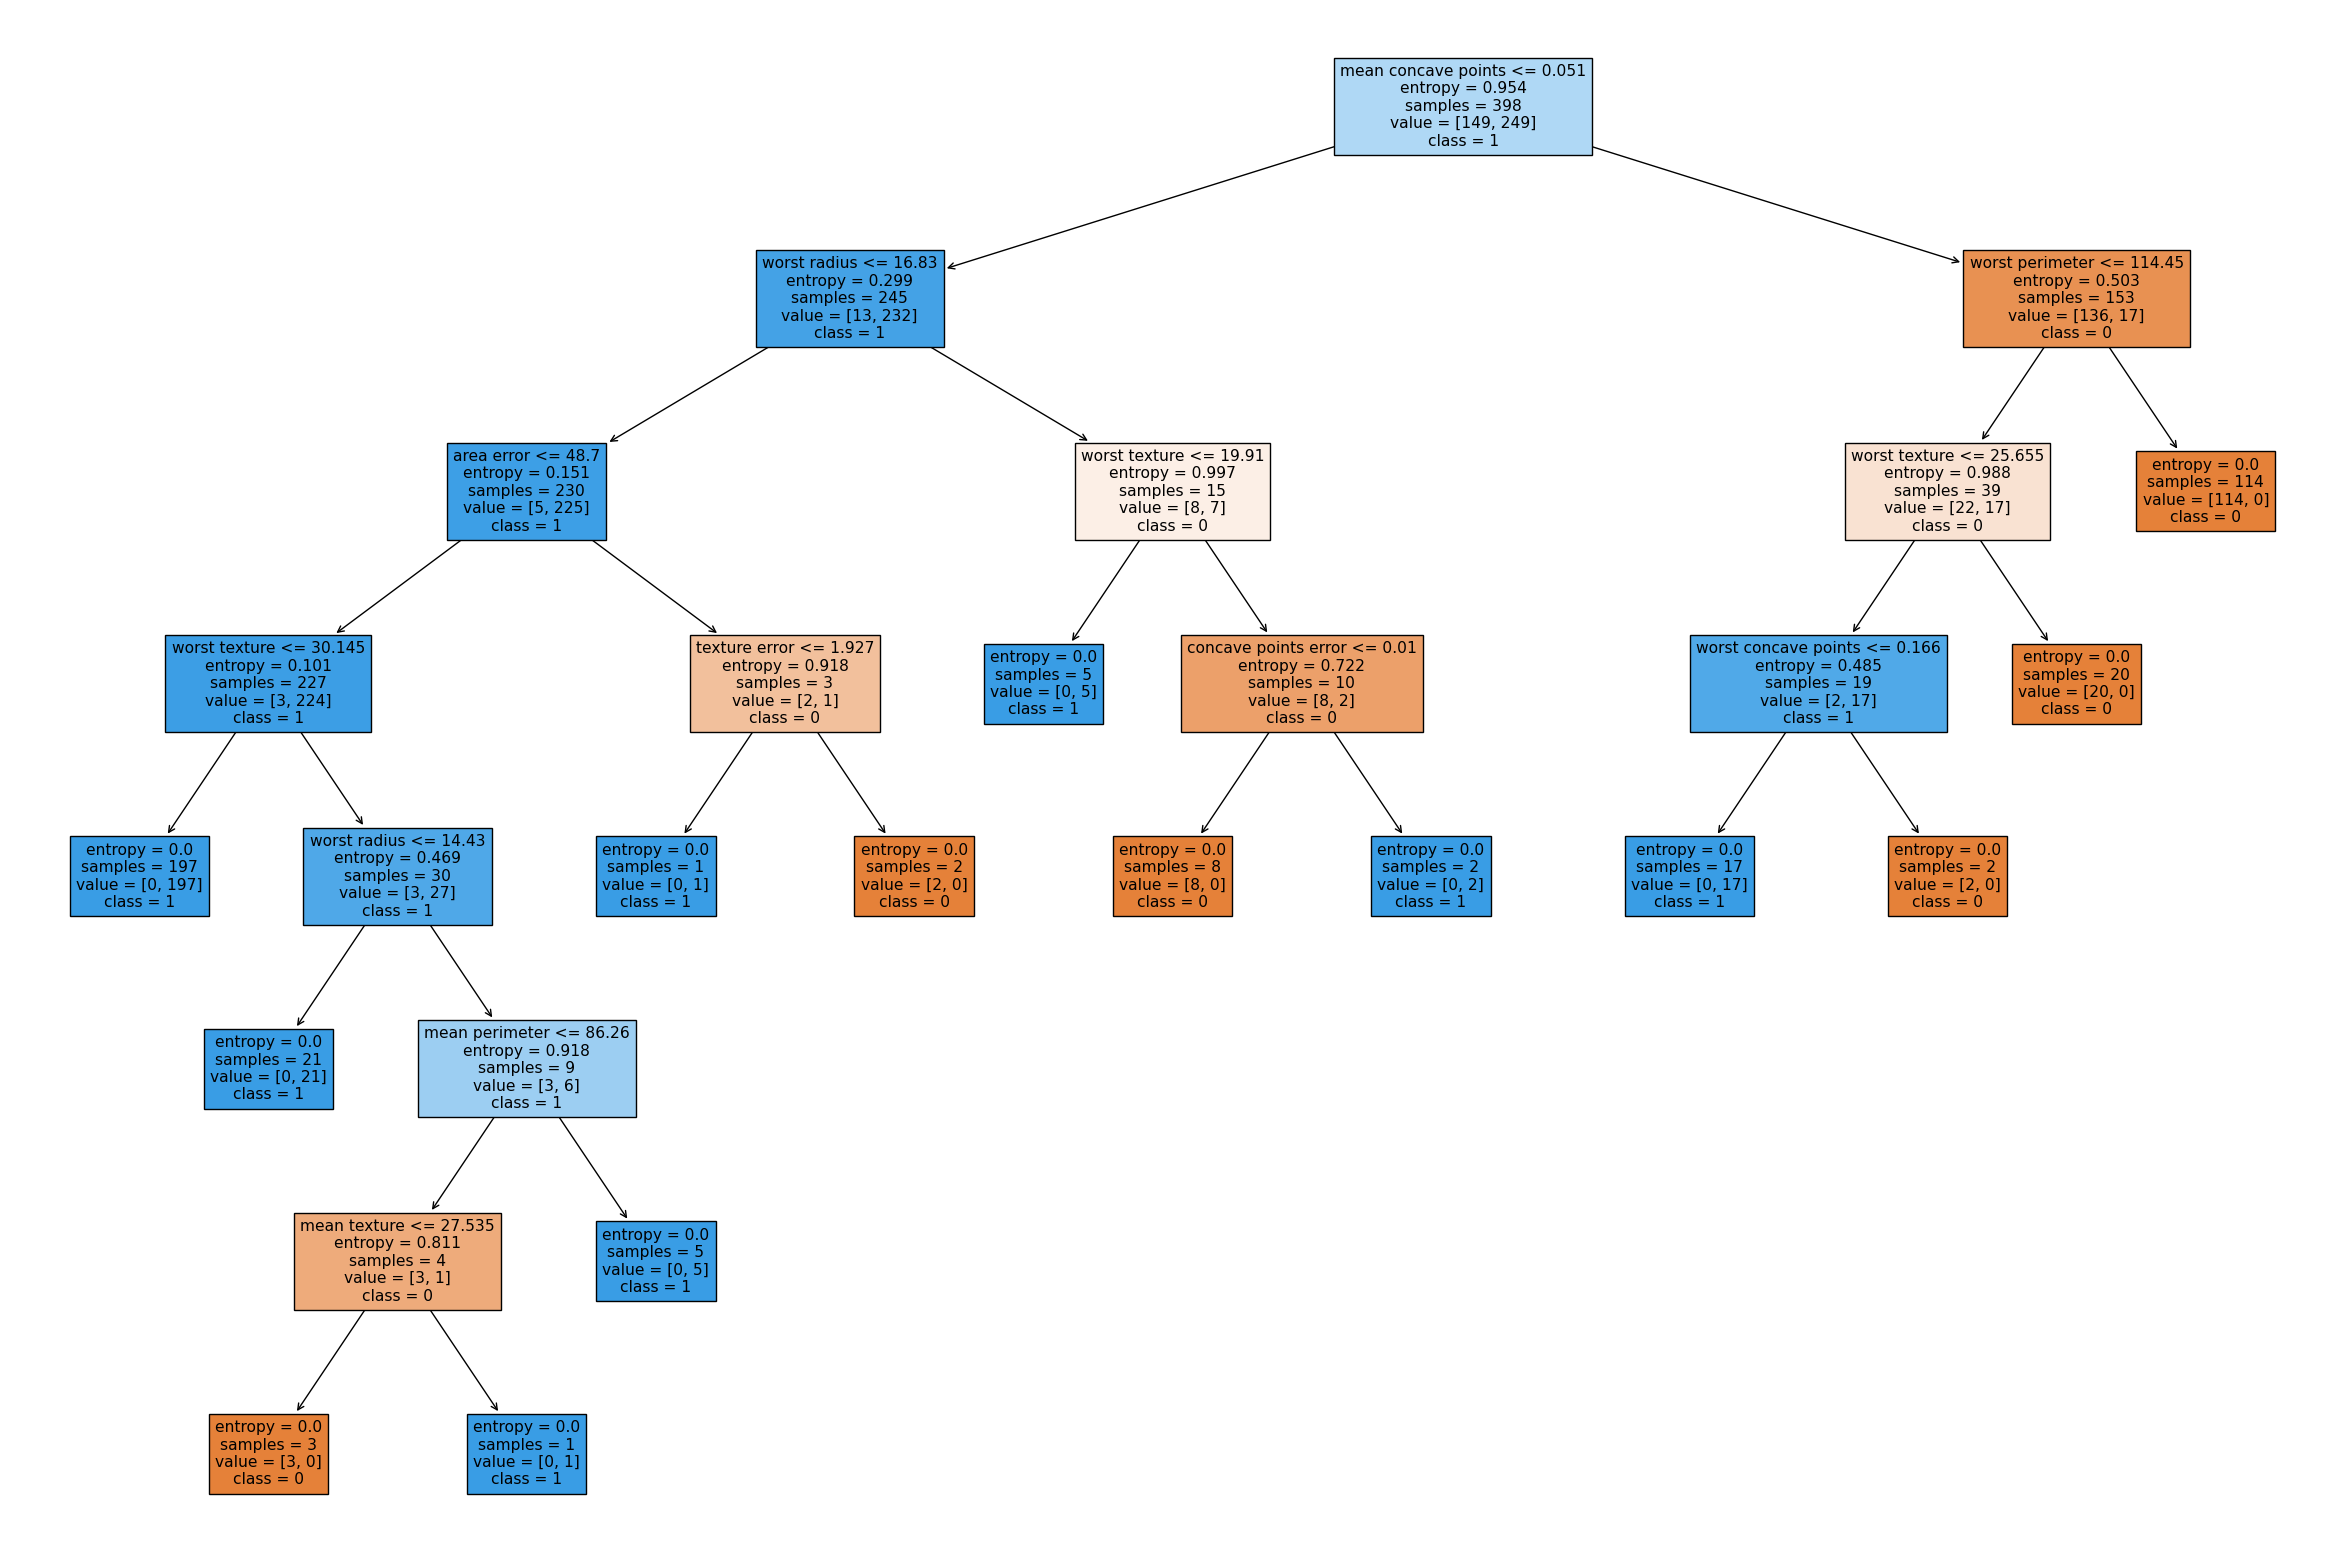

In [61]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

data = load_breast_cancer(as_frame=True)['data']
target = load_breast_cancer(as_frame=True)['target']

# Split data
X = data # Features
y = target    # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.6666, random_state=42)

# Initialize classifier
clf = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)
val_pred = clf.predict(X_val)
# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
val_accuracy = accuracy_score(y_val, val_pred)
print(f"Accuracy of the decision tree on the testing data: {accuracy:.3f}")
print(f"Accuracy of the decision tree on the validation data: {val_accuracy:.3f}")

#plot tree
plt.figure(figsize=(30, 20))
plot_tree(clf, feature_names=list(X_train.columns), class_names=['0', '1'], filled=True, impurity=True)
plt.savefig('tree_scikit.png', dpi=1200)
plt.show()


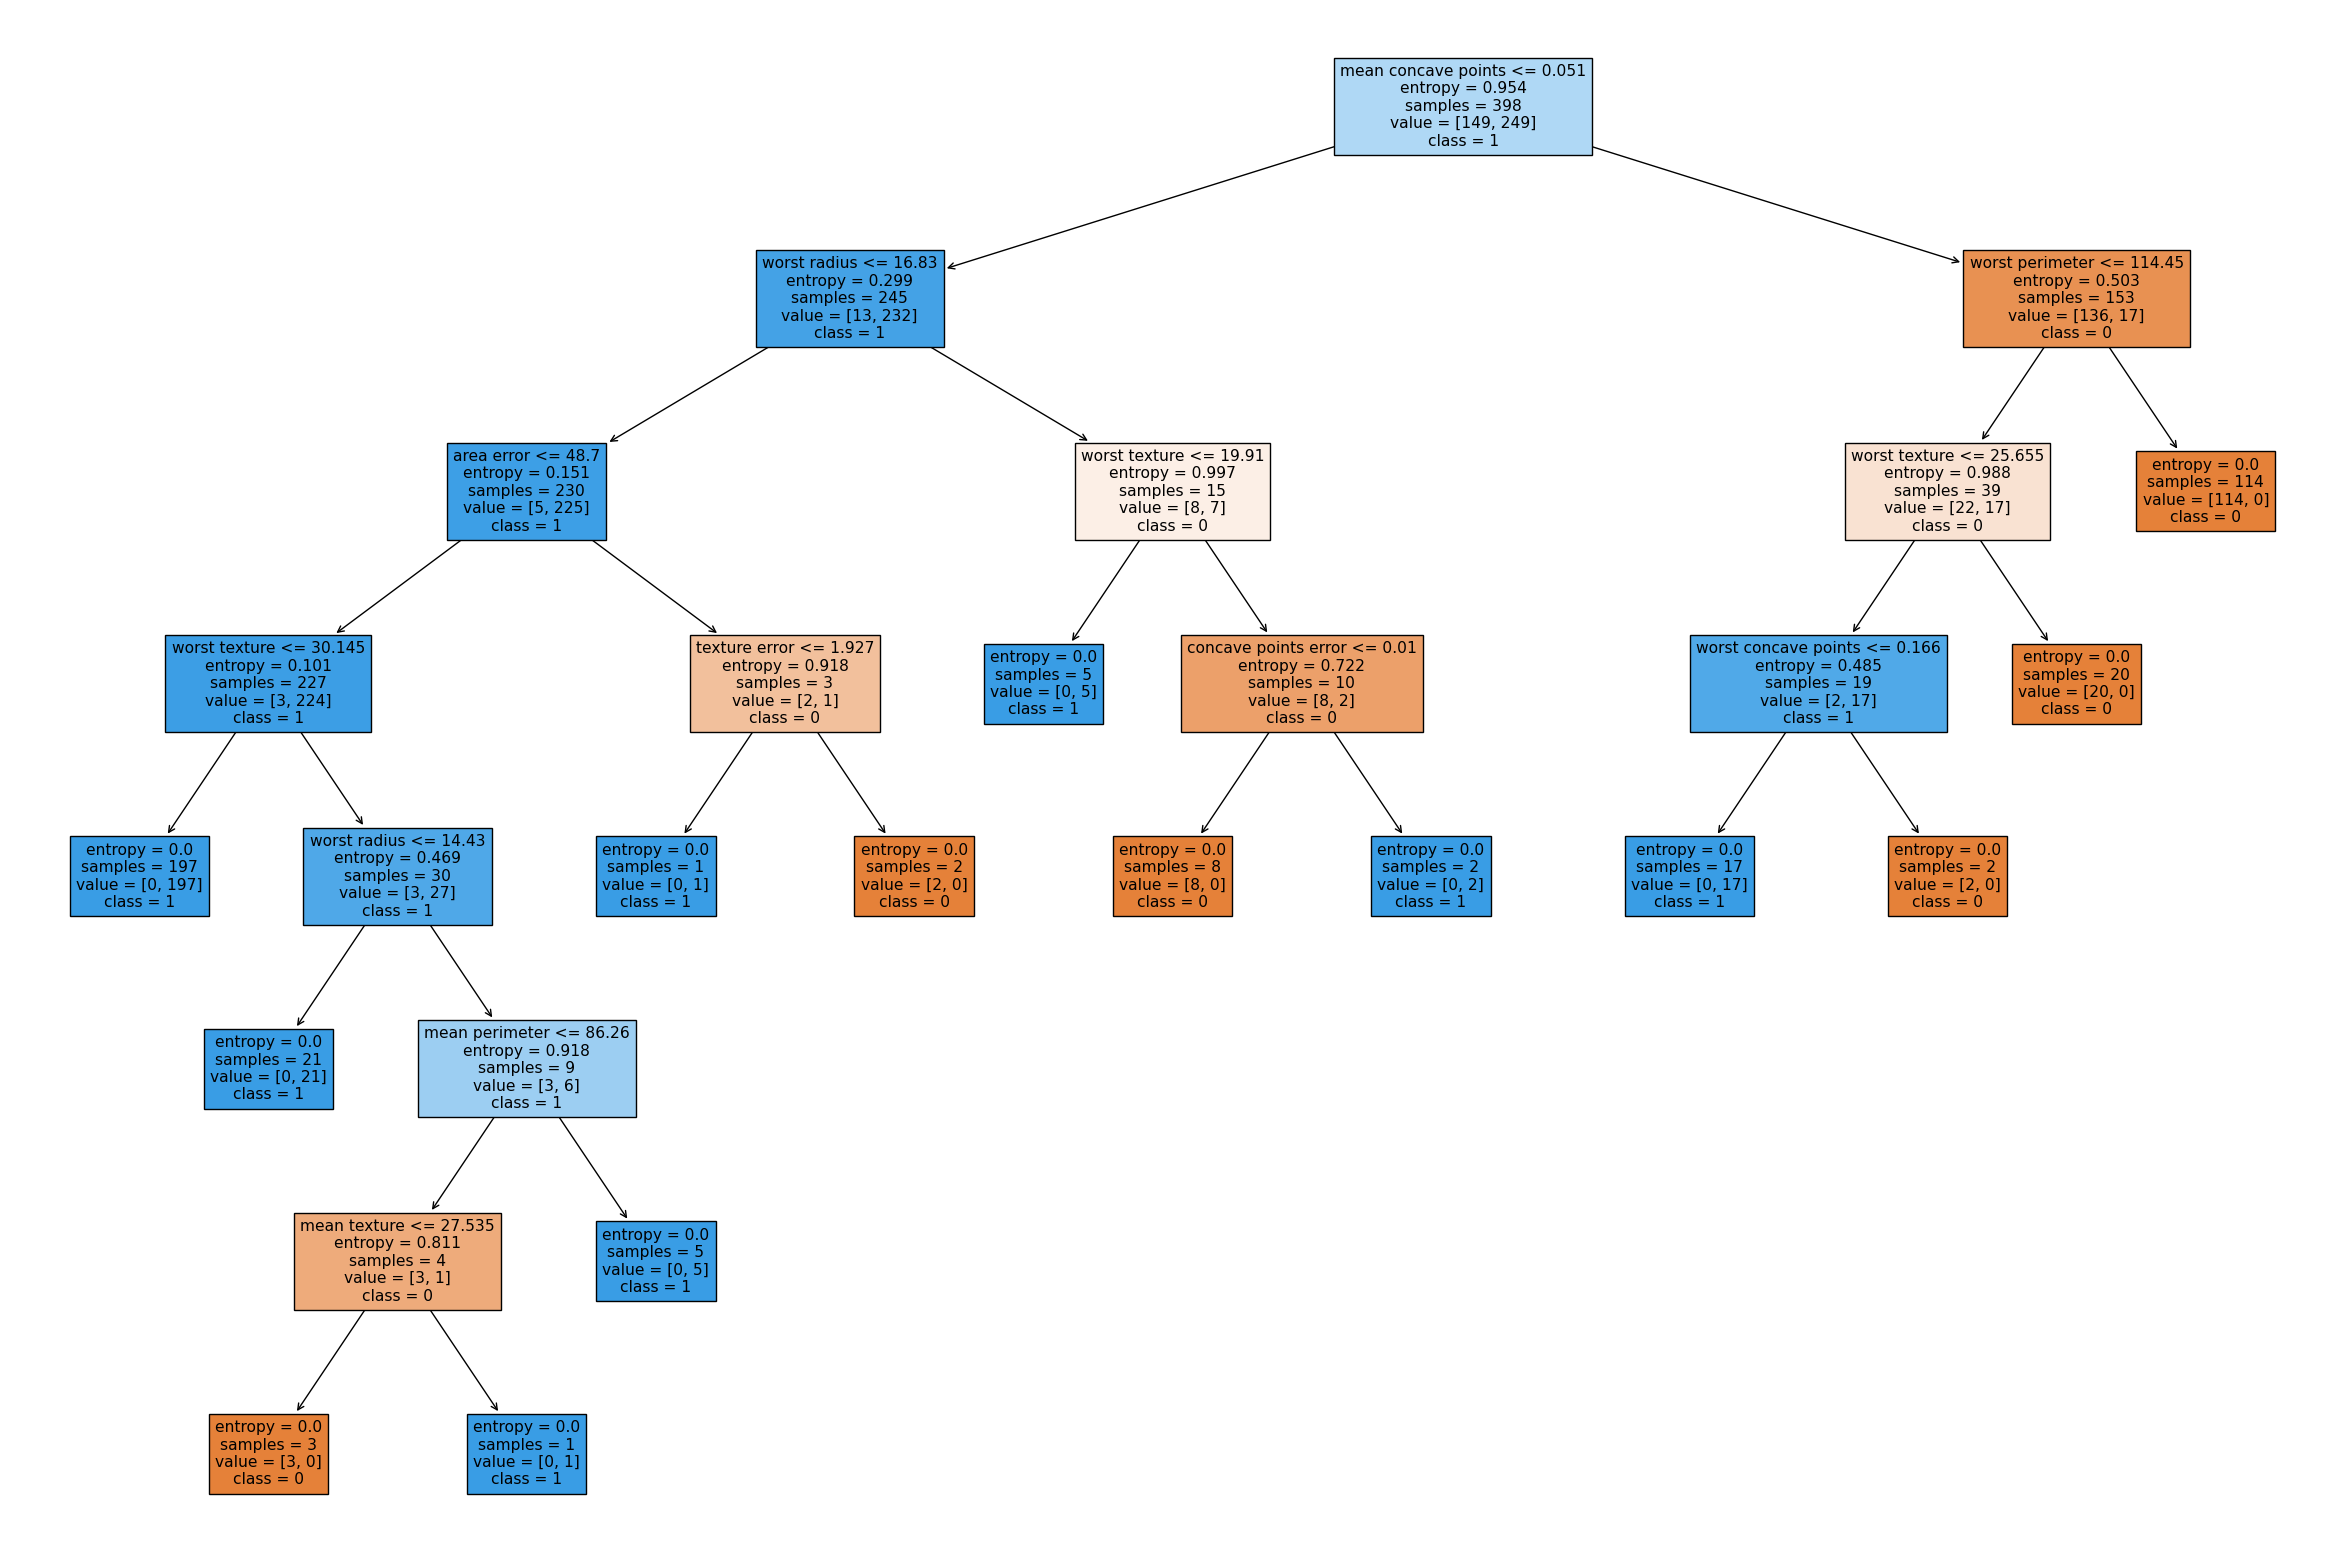